In [24]:
# import statements
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [4]:
# Loading data

# Fake data
articles = np.asarray([
    ["Donald Trump buys a dog", "Donald Trump recently was found buying a dog"],
    ["President Trump gets a corgie", "The White House welcomes a new furry friend, and its name is Evan!"],
    ["U.S. Presidential Paws", "You won't believe the new dog that Donald and the fam just got!"],
    ["Biden sells his old car", "President Biden just announced that he is selling is '96 Civic"],
    ["President Biden to sell car", "Biden announced via Twitter that he will indeed be selling his car"],
    ["Biden getting that car cash", "Biden is about to cash out once he sells that junker civic!"]
])

data = utils.toframe(utils.files)[0:100]

In [5]:
data.head()

,article_id,title,abstract,author,source,time_stamp,link,query
0,8685561245407504975,"F.D.A. Clears Johnson & Johnson’s Shot, the Th...",The authorization of a third Covid-19 vaccine ...,By Noah Weiland and Sharon LaFraniere,The New York Times,2021-02-27T23:12:09+0000,https://www.nytimes.com/2021/02/27/health/covi...,NaN
1,-4003416222667572167,New Findings on 2 Ways Children Become Serious...,A large study found that young people hospital...,By Pam Belluck,The New York Times,2021-02-24T21:32:35+0000,https://www.nytimes.com/2021/02/24/health/covi...,NaN
2,-9216745627564821742,"On the Post-Pandemic Horizon, Could That Be … ...","Signs of economic life are picking up, and mou...",By Ben Casselman,The New York Times,2021-02-21T20:00:08+0000,https://www.nytimes.com/2021/02/21/business/ec...,NaN
3,-1223795049129502898,2.5 Million Women Left the Work Force During t...,"“In one year,” Vice President Kamala Harris sa...",By Katie Rogers,The New York Times,2021-02-18T22:50:57+0000,https://www.nytimes.com/2021/02/18/us/politics...,NaN
4,1665149864120880813,"Covid Vaccines for Kids Are Coming, but Not fo...",Pfizer and Moderna are testing their vaccines ...,By Apoorva Mandavilli,The New York Times,2021-02-12T10:00:21+0000,https://www.nytimes.com/2021/02/12/health/covi...,NaN


In [6]:
# # Vectorizing 
# # Combining headlines and bodies
# a = [x[0] + ': ' + x[1] for x in articles]
# # Generating model 
# roberta = SentenceTransformer('stsb-roberta-base')
# v = utils.encode(a, roberta)

roberta = SentenceTransformer('stsb-roberta-base')
a = [x + ': ' + y for x,y in zip(data['title'], data['abstract'])]
v = utils.encode(a, roberta)

Time for computting embeddings:27.65540909767151


In [ ]:
# Retrieving related articles 

In [7]:
# Creating the graph
import networkx as nx

G = nx.Graph()

In [8]:
G.clear()
for root, v0 in zip(data['title'], v):
    for comp, v1 in zip(data['title'], v):
        if utils.doc_sim(v0,v1) > .5:
            G.add_edge(root, comp, weight=utils.doc_sim(v0,v1))

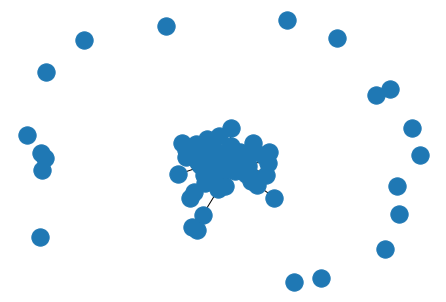

In [9]:
nx.draw(G)

In [11]:
from networkx.algorithms import community
from networkx import edge_betweenness_centrality as betweenness

def most_central_edge(G):

    centrality = betweenness(G, weight="weight")

    return max(centrality, key=centrality.get)

comp = community.girvan_newman(G, most_valuable_edge=most_central_edge)

communities =tuple(sorted(c) for c in next(comp))

In [31]:
# Extracting full articles from communities
cdf = []
for com in communities:
    df = pd.DataFrame()
    for art in com:
        x = data.loc[data['title'] == art]
        df = df.append(x)
    cdf.append(df)

In [75]:
# Reducing each community down to an article 
min_coms = [] 
for com in cdf:
    min_time = min(com['time_stamp'])
    df = pd.DataFrame()
    df = df.append(com.loc[com['time_stamp'] == min_time])
    min_coms.append(df)

In [99]:
el = nx.Graph()
el.clear()

# Generating Lv and Huang graph 
lv = sorted([(x,list(x['time_stamp'])) for x in min_coms], key = lambda x: x[1])
lv = [x[0] for x in lv]
for i in range(1, len(lv)):
    el.add_edge(str(lv[i-1]['title']), str(lv[i]['title']))

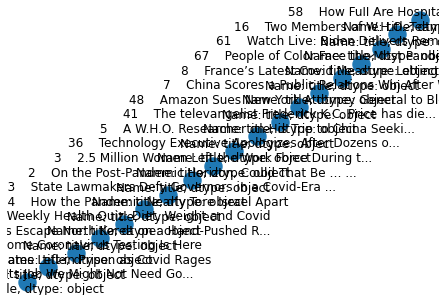

In [113]:
# Drawing the graph 
%matplotlib inline
nx.draw_kamada_kawai(el, with_labels=True)

In [ ]:
# Generating NewsChain event line 

# Defining similarity between sub-events 
# Similarity = avg_pairwise_eos 
# Rules for drawing edge, if sim > theta, draw directed edge based on min time 
el.clear()
